In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

In [3]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [4]:
import matplotlib.pyplot as plt

In [6]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [7]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [8]:
night_start = 10
path = "../neocp/neo/"
detection_window = 15
min_nights = 3
schedule_type = "predicted"

# create a list of nights in the detection window and get schedule for them
night_list = list(range(night_start, night_start + detection_window))

if schedule_type == "predicted":
    full_schedule = scheduling.get_LSST_schedule(night=night_start, schedule_type=schedule_type)
else:
    full_schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1),
                                                 schedule_type=schedule_type)

# offset the schedule by one row and re-merge to get the previous night column
shifted = full_schedule.shift()
full_schedule["previousNight"] = shifted["night"]

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

file = 0
visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")

# get the objects from the night
obs_mask = np.logical_and(visit_file["night"] == night_start, visit_file["scores"] >= 65)
sorted_obs = visit_file[obs_mask].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs.index.unique()

In [229]:
bright_enough = joined_table["mag_in_filter"] < joined_table["fiveSigmaDepth"]

# of those, find those which are roughly within the field (2.1 degrees)
# operating on a subset because SkyCoord gets slow for large datasets
in_current_field = np.repeat(False, len(joined_table))
bright_table = joined_table[bright_enough]
obj_pos = SkyCoord(ra=bright_table["RA_deg"], dec=bright_table["Dec_deg"], unit="degree", frame="icrs")
sch_pos = SkyCoord(ra=bright_table["fieldRA"], dec=bright_table["fieldDec"], unit="degree", frame="icrs")
in_current_field[bright_enough] = obj_pos.separation(sch_pos) <= 2.1 * u.deg

In [195]:
from rubin_sim.utils import LsstCameraFootprint

In [199]:
%env RUBIN_SIM_DATA_DIR=/epyc/ssd/users/tomwagg/rubin_sim_data

env: RUBIN_SIM_DATA_DIR=/epyc/ssd/users/tomwagg/rubin_sim_data


In [242]:
bright_enough

0          True
1          True
2          True
3          True
4          True
          ...  
379005    False
379006    False
379007    False
379008    False
379009    False
Length: 379010, dtype: bool

In [243]:
in_current_field

array([False, False, False, ..., False, False, False])

In [214]:
joined_table

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,night,previousNight,mag_in_filter,observed
0,0,I11,59649.207792,167.319086,-27.469360,-0.582231,0.347939,28.664736,148.477981,1.082645,0.103224,23.120602,300.862356,180.316695,-30.045436,10.019652,-30.043934,171.120750,-2.737573,0.823707,-2.736071,84.734114,-56.172855,-9.149770,0.564573,93.885033,-1.068449,0.166918,-0.051709,0.046724,-0.015741,0.029079,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.830602,False
1,1,I11,59649.207792,167.317817,-27.468131,-0.576114,0.350148,28.420663,148.479059,1.091123,0.112874,23.114720,301.290187,180.314896,-30.044842,10.017853,-30.043340,171.190796,-2.970280,0.893753,-2.968778,84.732530,-56.172855,-30.808605,0.485264,119.241540,-1.076804,0.166875,-0.056540,0.046715,-0.015637,0.029094,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.824720,False
2,2,I11,59649.207792,167.316426,-27.467019,-0.568035,0.351793,28.157582,148.480007,1.100443,0.123456,23.109344,301.770604,180.313046,-30.044402,10.016002,-30.042900,171.266371,-3.221316,0.969327,-3.219814,84.730908,-56.172855,-30.808605,0.485264,119.240675,-1.085964,0.166828,-0.061837,0.046705,-0.015529,0.029112,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.819344,False
3,3,I11,59649.207792,167.315061,-27.466088,-0.558916,0.353958,27.874438,148.480779,1.110687,0.135059,23.104432,302.345828,180.311313,-30.044112,10.014269,-30.042611,171.347814,-3.491729,1.050771,-3.490227,84.729396,-56.172855,-30.808605,0.485264,119.239983,-1.096008,0.166777,-0.067646,0.046691,-0.015413,0.029134,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.814432,False
4,4,I11,59649.207792,167.314191,-27.465255,-0.555330,0.356533,27.570032,148.481508,1.121950,0.147782,23.099946,302.701286,180.310084,-30.043714,10.013041,-30.042213,171.435498,-3.782525,1.138454,-3.781023,84.728315,-56.172855,-30.808605,0.485264,119.239308,-1.107022,0.166720,-0.074015,0.046679,-0.015273,0.029156,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.809946,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379507,1055,I11,59662.273518,162.069330,-23.456013,-0.263197,0.251699,6.837056,149.947307,4.193685,3.300984,24.028390,313.720696,173.412962,-28.524960,-9.885668,-28.524796,175.937150,-22.079263,-7.361480,-22.079099,47.766281,-52.121963,27.600810,0.504606,63.944853,-3.876374,0.275336,-1.576360,-0.055504,0.009140,-0.024522,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.738390,False
379508,1056,I11,59662.273518,161.940130,-23.372991,-0.276038,0.260864,6.466172,149.920407,4.436710,3.545841,23.965590,313.381115,173.250503,-28.501073,-10.048127,-28.500909,175.681052,-22.418044,-7.617578,-22.417880,47.626845,-52.121963,27.600810,0.504606,64.014650,-4.089763,0.308871,-1.691990,-0.055799,0.011797,-0.024094,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.675590,False
379509,1057,I11,59662.273518,161.881550,-23.330873,-0.285124,0.267469,6.100359,149.911060,4.702986,3.813792,23.905302,313.170015,173.174644,-28.486190,-10.123986,-28.486026,175.490282,-22.753734,-7.808347,-22.753570,47.562084,-52.121963,27.600810,0.504606,64.050751,-4.323553,0.341009,-1.818979,-0.056106,0.014355,-0.023639,-0.995245,-0.057362,-0.0

In [200]:
camera = LsstCameraFootprint(units='degrees')

In [290]:
unique_field_times = joined_table["mjd_utc"].unique()

In [291]:
%%time
in_footprint = np.repeat(False, len(joined_table))


for field_time in unique_field_times:
    field_table = joined_table[joined_table["mjd_utc"] == field_time]
    
    all_inds = np.arange(len(field_table))
    inds = camera(field_table["RA_deg"].values, field_table["Dec_deg"].values, field_table["fieldRA"].iloc[0], field_table["fieldDec"].iloc[0], field_table["rotSkyPos"].iloc[0])
    
    mask = np.isin(all_inds, inds)
    
    in_footprint[joined_table["mjd_utc"] == field_time] = mask
#     print(mask)

CPU times: user 1.2 s, sys: 62 ms, total: 1.26 s
Wall time: 1.26 s


In [295]:
3738+4281

8019

In [305]:
# work out which are bright enough to be detected
bright_enough = joined_table["mag_in_filter"] < joined_table["fiveSigmaDepth"]

in_footprint = np.repeat(False, len(joined_table))

# loop over each of the unique field times
unique_field_times = joined_table["mjd_utc"].unique()
for field_time in unique_field_times:
    # get just the table for this time
    time_mask = joined_table["mjd_utc"] == field_time
    field_table = joined_table[time_mask]

    # camera returns indices so we can convert that to a mask like so
    all_inds = np.arange(len(field_table))
    observed_inds = camera(field_table["RA_deg"].values, field_table["Dec_deg"].values,
                           field_table["fieldRA"].iloc[0], field_table["fieldDec"].iloc[0],
                           field_table["rotSkyPos"].iloc[0])
    observed_mask = np.isin(all_inds, observed_inds)

    in_footprint[time_mask] = observed_mask

# combine the masks into a single observed boolean
joined_table["observed"] = np.logical_and(in_footprint, bright_enough)

In [306]:
joined_table[joined_table["observed"]]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed,test
16610,0,I11,59649.263903,167.281589,-27.448589,-0.607979,0.390265,28.717470,148.510340,1.079843,0.099985,23.047280,302.696623,180.271580,-30.041784,9.917825,-30.040581,171.145615,-2.657977,0.791860,-2.656773,67.484170,-50.345863,-24.796645,0.569975,93.219006,-1.065826,0.166035,-0.050076,0.046741,-0.015745,0.029075,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867280,True,False
16611,1,I11,59649.263903,167.280690,-27.447364,-0.595806,0.390275,28.472326,148.511452,1.088318,0.109636,23.047409,303.226273,180.270123,-30.041047,9.916367,-30.039843,171.215343,-2.891859,0.861588,-2.890655,67.483127,-50.345863,-27.486978,0.485603,119.198416,-1.074181,0.165998,-0.054907,0.046729,-0.015646,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867409,True,False
16612,2,I11,59649.263903,167.279973,-27.446278,-0.589166,0.392469,28.208091,148.512447,1.097632,0.120218,23.047531,303.669288,180.268903,-30.040362,9.915148,-30.039158,171.290602,-3.144143,0.936847,-3.142939,67.482270,-50.345863,-27.486978,0.485603,119.197467,-1.083342,0.165957,-0.060203,0.046716,-0.015527,0.029116,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867531,True,False
16613,3,I11,59649.263903,167.279270,-27.445267,-0.579547,0.389671,27.923627,148.513369,1.107872,0.131821,23.047647,303.915809,180.267735,-30.039737,9.913980,-30.038534,171.371701,-3.415879,1.017946,-3.414675,67.481442,-50.345863,-27.486978,0.485603,119.196588,-1.093387,0.165912,-0.066010,0.046705,-0.015408,0.029134,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867647,True,False
16614,4,I11,59649.263903,167.278677,-27.444354,-0.573273,0.386995,27.617863,148.514208,1.119130,0.144543,23.047759,304.021782,180.266718,-30.039157,9.912963,-30.037953,171.458972,-3.708099,1.105217,-3.706895,67.480730,-50.345863,-27.486978,0.485603,119.195787,-1.104401,0.165862,-0.072378,0.046694,-0.015272,0.029152,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867759,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371658,274,I11,59662.182754,151.293451,-12.262054,-2.682686,3.084071,27.240276,146.759274,1.193832,0.227669,20.737541,318.981554,158.007467,-22.430399,-25.200079,-22.429764,178.891689,-4.173372,-4.315857,-4.172737,60.787843,-60.654510,31.175937,0.506062,74.029086,-1.190443,0.023030,-0.086881,0.023346,-0.010982,0.015700,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.447541,True,False
371690,323,I11,59662.182754,152.253299,-12.985746,-2.379148,2.780081,27.265607,147.431319,1.171379,0.201117,20.919649,319.443623,159.243525,-22.744389,-23.964021,-22.743754,179.512000,-3.806633,-3.695547,-3.805998,61.969368,-60.654510,31.175937,0.506062,73.388783,-1.168752,0.009955,-0.077767,0.018618,-0.012022,0.012649,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.629649,True,False
371720,370,I11,59662.182754,150.681351,-10.669783,-2.976960,3.597847,29.858827,146.606967,1.102024,0.123431,20.746961,320.394689,156.765844,-21.178873,-26.441702,-21.178238,180.539852,-2.

In [304]:
joined_table[np.logical_and(in_footprint, bright_enough)]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed,test
16610,0,I11,59649.263903,167.281589,-27.448589,-0.607979,0.390265,28.717470,148.510340,1.079843,0.099985,23.047280,302.696623,180.271580,-30.041784,9.917825,-30.040581,171.145615,-2.657977,0.791860,-2.656773,67.484170,-50.345863,-24.796645,0.569975,93.219006,-1.065826,0.166035,-0.050076,0.046741,-0.015745,0.029075,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867280,True,False
16611,1,I11,59649.263903,167.280690,-27.447364,-0.595806,0.390275,28.472326,148.511452,1.088318,0.109636,23.047409,303.226273,180.270123,-30.041047,9.916367,-30.039843,171.215343,-2.891859,0.861588,-2.890655,67.483127,-50.345863,-27.486978,0.485603,119.198416,-1.074181,0.165998,-0.054907,0.046729,-0.015646,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867409,True,False
16612,2,I11,59649.263903,167.279973,-27.446278,-0.589166,0.392469,28.208091,148.512447,1.097632,0.120218,23.047531,303.669288,180.268903,-30.040362,9.915148,-30.039158,171.290602,-3.144143,0.936847,-3.142939,67.482270,-50.345863,-27.486978,0.485603,119.197467,-1.083342,0.165957,-0.060203,0.046716,-0.015527,0.029116,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867531,True,False
16613,3,I11,59649.263903,167.279270,-27.445267,-0.579547,0.389671,27.923627,148.513369,1.107872,0.131821,23.047647,303.915809,180.267735,-30.039737,9.913980,-30.038534,171.371701,-3.415879,1.017946,-3.414675,67.481442,-50.345863,-27.486978,0.485603,119.196588,-1.093387,0.165912,-0.066010,0.046705,-0.015408,0.029134,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867647,True,False
16614,4,I11,59649.263903,167.278677,-27.444354,-0.573273,0.386995,27.617863,148.514208,1.119130,0.144543,23.047759,304.021782,180.266718,-30.039157,9.912963,-30.037953,171.458972,-3.708099,1.105217,-3.706895,67.480730,-50.345863,-27.486978,0.485603,119.195787,-1.104401,0.165862,-0.072378,0.046694,-0.015272,0.029152,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867759,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371658,274,I11,59662.182754,151.293451,-12.262054,-2.682686,3.084071,27.240276,146.759274,1.193832,0.227669,20.737541,318.981554,158.007467,-22.430399,-25.200079,-22.429764,178.891689,-4.173372,-4.315857,-4.172737,60.787843,-60.654510,31.175937,0.506062,74.029086,-1.190443,0.023030,-0.086881,0.023346,-0.010982,0.015700,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.447541,True,False
371690,323,I11,59662.182754,152.253299,-12.985746,-2.379148,2.780081,27.265607,147.431319,1.171379,0.201117,20.919649,319.443623,159.243525,-22.744389,-23.964021,-22.743754,179.512000,-3.806633,-3.695547,-3.805998,61.969368,-60.654510,31.175937,0.506062,73.388783,-1.168752,0.009955,-0.077767,0.018618,-0.012022,0.012649,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.629649,True,False
371720,370,I11,59662.182754,150.681351,-10.669783,-2.976960,3.597847,29.858827,146.606967,1.102024,0.123431,20.746961,320.394689,156.765844,-21.178873,-26.441702,-21.178238,180.539852,-2.

In [302]:
joined_table[np.logical_and(np.logical_not(in_current_field), in_footprint)]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed,test
57401,21,I11,59651.285896,165.943349,-26.494738,-0.718513,0.581437,19.274070,149.702836,1.518930,0.575689,22.525883,308.980577,178.549668,-29.720468,6.177391,-29.719459,174.438901,-10.830999,2.066624,-10.829989,57.528218,-46.450376,-25.106887,0.498697,117.305126,-1.484850,0.144573,-0.285426,0.046347,-0.009481,0.030163,-0.985050,0.131919,-0.000018,-5672.282172,1497,166.654194,-26.932640,59651.285896,y,22.193472,307.068706,12,12.0,22.225883,False,False
57402,22,I11,59651.285896,165.975281,-26.524579,-0.687923,0.552499,18.489125,149.680810,1.582057,0.642484,22.568082,308.769386,178.594416,-29.734503,6.222138,-29.733494,174.608513,-11.620753,2.236236,-11.619743,57.563472,-46.450376,-25.106887,0.498697,117.329346,-1.542773,0.145604,-0.318678,0.046278,-0.008841,0.030245,-0.985050,0.131919,-0.000018,-5672.282172,1497,166.654194,-26.932640,59651.285896,y,22.193472,307.068706,12,12.0,22.268082,False,False
57403,23,I11,59651.285896,165.996660,-26.537568,-0.664957,0.535203,17.688062,149.672821,1.651652,0.715727,22.606359,308.829491,178.620798,-29.737638,6.248521,-29.736628,174.775634,-12.413174,2.403357,-12.412164,57.585280,-46.450376,-25.106887,0.498697,117.338685,-1.606340,0.146877,-0.355039,0.046176,-0.008067,0.030384,-0.985050,0.131919,-0.000018,-5672.282172,1497,166.654194,-26.932640,59651.285896,y,22.193472,307.068706,12,12.0,22.306359,False,False
57404,24,I11,59651.285896,166.016841,-26.559587,-0.644300,0.514075,16.888703,149.655791,1.728263,0.796031,22.641495,308.585741,178.650696,-29.749336,6.278419,-29.748326,174.946939,-13.212355,2.574662,-13.211346,57.608343,-46.450376,-25.106887,0.498697,117.357100,-1.675976,0.148193,-0.395013,0.046096,-0.007259,0.030484,-0.985050,0.131919,-0.000018,-5672.282172,1497,166.654194,-26.932640,59651.285896,y,22.193472,307.068706,12,12.0,22.341495,False,False
57405,25,I11,59651.285896,166.031524,-26.567410,-0.627858,0.502194,16.082481,149.651348,1.812680,0.884085,22.673622,308.654682,178.668252,-29.750504,6.295975,-29.749494,175.115444,-14.006337,2.743167,-14.005327,57.623034,-46.450376,-25.106887,0.498697,117.362433,-1.752400,0.149758,-0.438722,0.045976,-0.006311,0.030654,-0.985050,0.131919,-0.000018,-5672.282172,1497,166.654194,-26.932640,59651.285896,y,22.193472,307.068706,12,12.0,22.373622,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375344,153,I11,59662.250165,349.165378,28.042789,0.056096,-0.140177,131.365519,29.837771,0.660884,0.427989,29.721744,158.189643,2.298331,29.823525,179.023124,29.823803,183.854921,18.787811,0.579715,18.788090,-62.448030,-56.780958,28.494322,0.504951,119.922243,-0.624255,-0.042064,0.212847,0.037116,-0.016079,0.019638,-0.995264,-0.056954,-0.000005,-5672.282172,11161,168.313299,-27.101665,59662.250165,z,23.025711,300.467950,23,23.0,29.421744,False,False
375345,154,I11,59662.250165,349.349120,28.226313,0.047047,-0.141284,131.886213,29.921801,0.667946,0.418057,29.538019,161.582564,2.560509,29.914333,179.285303,29.914611,183.683313,18.187283,0.408106,18.187561,-62.643353,-56.780958,28.494322,0.504951,120.085626,-0.633265,-0.040766,0.208482,0.037009,-0.015979,0.019710,-0.995264,-0.056954,-0.000005,-5672.282172,11161,168.313299,-27.101665,59662.250165,z,23.025711,300.467950,23,23.0,29.238019,False,False
375346,155,I11,59662.250165,349.580977,28.441964,0.035410,-0.143885,132.439514,30.016683,0.675751,0.407184,29.353511,166.174416,2.883075,30.014638,179.607868,30.014916

(array([   4.,   18.,   30.,   79.,  121.,   59., 1594., 1657.,  398.,
         321.]),
 array([0.8377754 , 0.84607553, 0.85437567, 0.86267581, 0.87097595,
        0.87927609, 0.88757622, 0.89587636, 0.9041765 , 0.91247664,
        0.92077678]),
 <BarContainer object of 10 artists>)

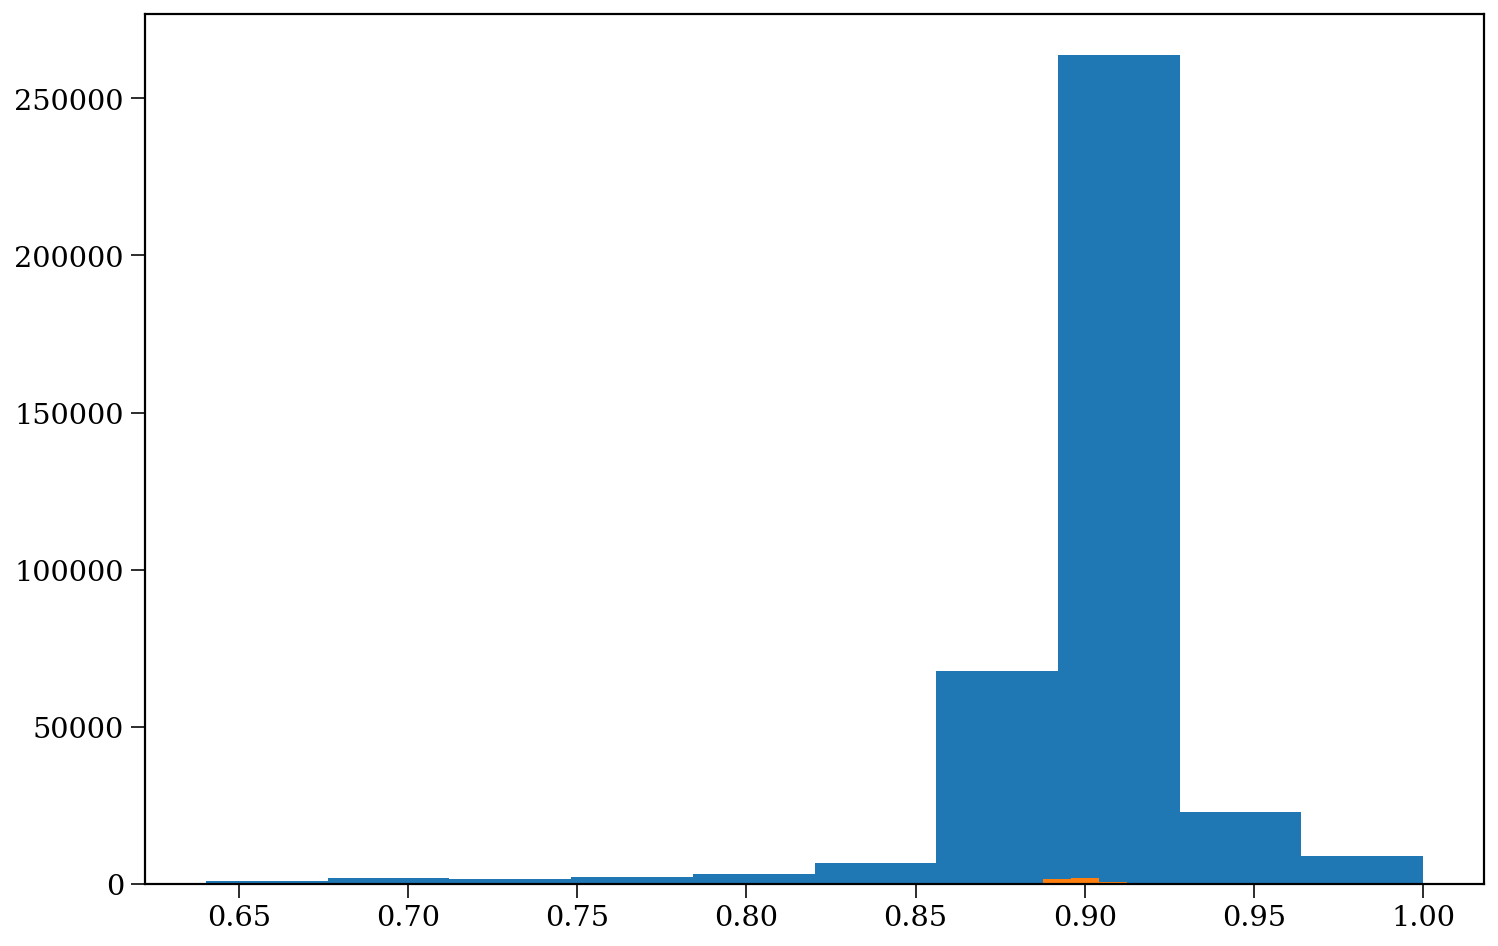

In [301]:
plt.hist(np.cos(np.radians(joined_table["Dec_deg"])))
plt.hist(np.cos(np.radians(joined_table[np.logical_and(np.logical_not(in_current_field), in_footprint)]["Dec_deg"])))

In [292]:
joined_table[in_footprint]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed,test
16610,0,I11,59649.263903,167.281589,-27.448589,-0.607979,0.390265,28.717470,148.510340,1.079843,0.099985,23.047280,302.696623,180.271580,-30.041784,9.917825,-30.040581,171.145615,-2.657977,0.791860,-2.656773,67.484170,-50.345863,-24.796645,0.569975,93.219006,-1.065826,0.166035,-0.050076,0.046741,-0.015745,0.029075,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867280,True,False
16611,1,I11,59649.263903,167.280690,-27.447364,-0.595806,0.390275,28.472326,148.511452,1.088318,0.109636,23.047409,303.226273,180.270123,-30.041047,9.916367,-30.039843,171.215343,-2.891859,0.861588,-2.890655,67.483127,-50.345863,-27.486978,0.485603,119.198416,-1.074181,0.165998,-0.054907,0.046729,-0.015646,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867409,True,False
16612,2,I11,59649.263903,167.279973,-27.446278,-0.589166,0.392469,28.208091,148.512447,1.097632,0.120218,23.047531,303.669288,180.268903,-30.040362,9.915148,-30.039158,171.290602,-3.144143,0.936847,-3.142939,67.482270,-50.345863,-27.486978,0.485603,119.197467,-1.083342,0.165957,-0.060203,0.046716,-0.015527,0.029116,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867531,True,False
16613,3,I11,59649.263903,167.279270,-27.445267,-0.579547,0.389671,27.923627,148.513369,1.107872,0.131821,23.047647,303.915809,180.267735,-30.039737,9.913980,-30.038534,171.371701,-3.415879,1.017946,-3.414675,67.481442,-50.345863,-27.486978,0.485603,119.196588,-1.093387,0.165912,-0.066010,0.046705,-0.015408,0.029134,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867647,True,False
16614,4,I11,59649.263903,167.278677,-27.444354,-0.573273,0.386995,27.617863,148.514208,1.119130,0.144543,23.047759,304.021782,180.266718,-30.039157,9.912963,-30.037953,171.458972,-3.708099,1.105217,-3.706895,67.480730,-50.345863,-27.486978,0.485603,119.195787,-1.104401,0.165862,-0.072378,0.046694,-0.015272,0.029152,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867759,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375344,153,I11,59662.250165,349.165378,28.042789,0.056096,-0.140177,131.365519,29.837771,0.660884,0.427989,29.721744,158.189643,2.298331,29.823525,179.023124,29.823803,183.854921,18.787811,0.579715,18.788090,-62.448030,-56.780958,28.494322,0.504951,119.922243,-0.624255,-0.042064,0.212847,0.037116,-0.016079,0.019638,-0.995264,-0.056954,-0.000005,-5672.282172,11161,168.313299,-27.101665,59662.250165,z,23.025711,300.467950,23,23.0,29.421744,False,False
375345,154,I11,59662.250165,349.349120,28.226313,0.047047,-0.141284,131.886213,29.921801,0.667946,0.418057,29.538019,161.582564,2.560509,29.914333,179.285303,29.914611,183.683313,18.187283,0.408106,18.187561,-62.643353,-56.780958,28.494322,0.504951,120.085626,-0.633265,-0.040766,0.208482,0.037009,-0.015979,0.019710,-0.995264,-0.056954,-0.000005,-5672.282172,11161,168.313299,-27.101665,59662.250165,z,23.025711,300.467950,23,23.0,29.238019,False,False
375346,155,I11,59662.250165,349.580977,28.441964,0.035410,-0.143885,132.439514,30.016683,0.675751,0.407184,29.353511,166.174416,2.883075,30.014638,179.607868,30.014916,183.489785,17.542252,0.21

In [241]:
joined_table[in_current_field][in_footprint]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed
16610,0,I11,59649.263903,167.281589,-27.448589,-0.607979,0.390265,28.717470,148.510340,1.079843,0.099985,23.047280,302.696623,180.271580,-30.041784,9.917825,-30.040581,171.145615,-2.657977,0.791860,-2.656773,67.484170,-50.345863,-24.796645,0.569975,93.219006,-1.065826,0.166035,-0.050076,0.046741,-0.015745,0.029075,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867280,True
16611,1,I11,59649.263903,167.280690,-27.447364,-0.595806,0.390275,28.472326,148.511452,1.088318,0.109636,23.047409,303.226273,180.270123,-30.041047,9.916367,-30.039843,171.215343,-2.891859,0.861588,-2.890655,67.483127,-50.345863,-27.486978,0.485603,119.198416,-1.074181,0.165998,-0.054907,0.046729,-0.015646,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867409,True
16612,2,I11,59649.263903,167.279973,-27.446278,-0.589166,0.392469,28.208091,148.512447,1.097632,0.120218,23.047531,303.669288,180.268903,-30.040362,9.915148,-30.039158,171.290602,-3.144143,0.936847,-3.142939,67.482270,-50.345863,-27.486978,0.485603,119.197467,-1.083342,0.165957,-0.060203,0.046716,-0.015527,0.029116,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867531,True
16613,3,I11,59649.263903,167.279270,-27.445267,-0.579547,0.389671,27.923627,148.513369,1.107872,0.131821,23.047647,303.915809,180.267735,-30.039737,9.913980,-30.038534,171.371701,-3.415879,1.017946,-3.414675,67.481442,-50.345863,-27.486978,0.485603,119.196588,-1.093387,0.165912,-0.066010,0.046705,-0.015408,0.029134,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867647,True
16614,4,I11,59649.263903,167.278677,-27.444354,-0.573273,0.386995,27.617863,148.514208,1.119130,0.144543,23.047759,304.021782,180.266718,-30.039157,9.912963,-30.037953,171.458972,-3.708099,1.105217,-3.706895,67.480730,-50.345863,-27.486978,0.485603,119.195787,-1.104401,0.165862,-0.072378,0.046694,-0.015272,0.029152,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867759,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371658,274,I11,59662.182754,151.293451,-12.262054,-2.682686,3.084071,27.240276,146.759274,1.193832,0.227669,20.737541,318.981554,158.007467,-22.430399,-25.200079,-22.429764,178.891689,-4.173372,-4.315857,-4.172737,60.787843,-60.654510,31.175937,0.506062,74.029086,-1.190443,0.023030,-0.086881,0.023346,-0.010982,0.015700,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.447541,True
371690,323,I11,59662.182754,152.253299,-12.985746,-2.379148,2.780081,27.265607,147.431319,1.171379,0.201117,20.919649,319.443623,159.243525,-22.744389,-23.964021,-22.743754,179.512000,-3.806633,-3.695547,-3.805998,61.969368,-60.654510,31.175937,0.506062,73.388783,-1.168752,0.009955,-0.077767,0.018618,-0.012022,0.012649,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.629649,True
371720,370,I11,59662.182754,150.681351,-10.669783,-2.976960,3.597847,29.858827,146.606967,1.102024,0.123431,20.746961,320.394689,156.765844,-21.178873,-26.441702,-21.178238,180.539852,-2.319665,-2.667694,-2.319030,59.277796,-60.654510,31.

In [272]:
joined_table.loc[in_current_field, "test"][in_footprint] = True

In [274]:
joined_table["test"].any()

False

In [261]:
joined_table["test"] = np.repeat(False, len(joined_table))

In [288]:
joined_table["mjd_utc"].unique()

array([59649.20779192, 59649.20834996, 59649.22404133, 59649.22870974,
       59649.23249229, 59649.23299323, 59649.24851567, 59649.25408958,
       59649.25453788, 59649.25498805, 59649.2554485 , 59649.25687461,
       59649.25929192, 59649.25976249, 59649.26022137, 59649.26069061,
       59649.26115886, 59649.26161759, 59649.26208617, 59649.26253606,
       59649.26299595, 59649.26344562, 59649.26390325, 59649.2643644 ,
       59649.26482711, 59649.26527511, 59649.26572274, 59649.27869354,
       59649.27914148, 59649.27958877, 59649.28004835, 59649.28144769,
       59649.28382379, 59649.2842908 , 59649.28474968, 59649.28521809,
       59649.28568634, 59649.28614507, 59649.28661365, 59649.28706334,
       59649.28752323, 59649.28797272, 59649.28843035, 59649.28889151,
       59649.28935421, 59649.28980249, 59649.29024993, 59649.29570866,
       59649.29615629, 59649.32017971, 59649.32062729, 59649.33961475,
       59649.34006068, 59649.36217734, 59649.36262638, 59649.36530893,
      

In [280]:
joined_table[np.isin(joined_table.index, joined_table[in_current_field][in_footprint].index)]

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,rotSkyPos,night,previousNight,mag_in_filter,observed,test
16610,0,I11,59649.263903,167.281589,-27.448589,-0.607979,0.390265,28.717470,148.510340,1.079843,0.099985,23.047280,302.696623,180.271580,-30.041784,9.917825,-30.040581,171.145615,-2.657977,0.791860,-2.656773,67.484170,-50.345863,-24.796645,0.569975,93.219006,-1.065826,0.166035,-0.050076,0.046741,-0.015745,0.029075,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867280,True,False
16611,1,I11,59649.263903,167.280690,-27.447364,-0.595806,0.390275,28.472326,148.511452,1.088318,0.109636,23.047409,303.226273,180.270123,-30.041047,9.916367,-30.039843,171.215343,-2.891859,0.861588,-2.890655,67.483127,-50.345863,-27.486978,0.485603,119.198416,-1.074181,0.165998,-0.054907,0.046729,-0.015646,0.029095,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867409,True,False
16612,2,I11,59649.263903,167.279973,-27.446278,-0.589166,0.392469,28.208091,148.512447,1.097632,0.120218,23.047531,303.669288,180.268903,-30.040362,9.915148,-30.039158,171.290602,-3.144143,0.936847,-3.142939,67.482270,-50.345863,-27.486978,0.485603,119.197467,-1.083342,0.165957,-0.060203,0.046716,-0.015527,0.029116,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867531,True,False
16613,3,I11,59649.263903,167.279270,-27.445267,-0.579547,0.389671,27.923627,148.513369,1.107872,0.131821,23.047647,303.915809,180.267735,-30.039737,9.913980,-30.038534,171.371701,-3.415879,1.017946,-3.414675,67.481442,-50.345863,-27.486978,0.485603,119.196588,-1.093387,0.165912,-0.066010,0.046705,-0.015408,0.029134,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867647,True,False
16614,4,I11,59649.263903,167.278677,-27.444354,-0.573273,0.386995,27.617863,148.514208,1.119130,0.144543,23.047759,304.021782,180.266718,-30.039157,9.912963,-30.037953,171.458972,-3.708099,1.105217,-3.706895,67.480730,-50.345863,-27.486978,0.485603,119.195787,-1.104401,0.165862,-0.072378,0.046694,-0.015272,0.029152,-0.979274,0.166445,-0.000021,-5672.282172,118,167.092930,-28.567007,59649.263903,r,24.466611,-32.101291,10,10.0,22.867759,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371658,274,I11,59662.182754,151.293451,-12.262054,-2.682686,3.084071,27.240276,146.759274,1.193832,0.227669,20.737541,318.981554,158.007467,-22.430399,-25.200079,-22.429764,178.891689,-4.173372,-4.315857,-4.172737,60.787843,-60.654510,31.175937,0.506062,74.029086,-1.190443,0.023030,-0.086881,0.023346,-0.010982,0.015700,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.447541,True,False
371690,323,I11,59662.182754,152.253299,-12.985746,-2.379148,2.780081,27.265607,147.431319,1.171379,0.201117,20.919649,319.443623,159.243525,-22.744389,-23.964021,-22.743754,179.512000,-3.806633,-3.695547,-3.805998,61.969368,-60.654510,31.175937,0.506062,73.388783,-1.168752,0.009955,-0.077767,0.018618,-0.012022,0.012649,-0.995312,-0.055778,-0.000011,-5672.282172,11018,151.998054,-11.723639,59662.182754,i,23.538603,249.589873,23,23.0,20.629649,True,False
371720,370,I11,59662.182754,150.681351,-10.669783,-2.976960,3.597847,29.858827,146.606967,1.102024,0.123431,20.746961,320.394689,156.765844,-21.178873,-26.441702,-21.178238,180.539852,-2.

In [276]:
joined_table.at[np.isin(joined_table.index, joined_table[in_current_field][in_footprint].index), "test"] = True

InvalidIndexError: [False False False ... False False False]

In [265]:
joined_table["test"].any()

False

In [258]:
joined_table[in_current_field][in_footprint].index

Int64Index([ 16610,  16611,  16612,  16613,  16614,  16615,  16616,  16617,
             16618,  16619,
            ...
            369486, 369511, 371557, 371592, 371625, 371658, 371690, 371720,
            371721, 371750],
           dtype='int64', length=3738)

In [255]:
in_footprint

array([ True,  True,  True, ...,  True, False, False])

In [248]:
unique_field_times = joined_table[in_current_field]["rotSkyPos"].unique()
len(unique_field_times)

49

In [186]:
joined_table

,orbit_id,observatory_code,mjd_utc,RA_deg,Dec_deg,vRAcosDec,vDec,PhaseAngle_deg,SolarElon_deg,r_au,delta_au,VMag,PosAngle_deg,TLon_deg,TLat_deg,TOCLon_deg,TOCLat_deg,HLon_deg,HLat_deg,HOCLon_deg,HOCLat_deg,Alt_deg,SolarAlt_deg,LunarAlt_deg,LunarPhase,LunarElon_deg,obj_x,obj_y,obj_z,obj_vx,obj_vy,obj_vz,obs_x,obs_y,obs_z,TrueAnom,index,fieldRA,fieldDec,observationStartMJD,filter,fiveSigmaDepth,night,previousNight,mag_in_filter,observed
0,0,I11,59649.207792,167.319078,-27.469167,-0.581959,0.345389,28.664562,148.478171,1.082645,0.103224,23.120599,300.688881,180.316588,-30.045267,10.019545,-30.043765,171.120743,-2.737559,0.823699,-2.736057,84.734013,-56.172855,-9.149770,0.564573,93.884935,-1.068449,0.166918,-0.051708,0.046726,-0.015743,0.029075,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.830599,False
1,1,I11,59649.207792,167.317872,-27.468234,-0.577008,0.350963,28.420751,148.478962,1.091123,0.112874,23.114721,301.309919,180.315000,-30.044913,10.017956,-30.043411,171.190805,-2.970286,0.893761,-2.968784,84.732623,-56.172855,-30.808605,0.485264,119.241632,-1.076804,0.166875,-0.056540,0.046715,-0.015635,0.029094,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.824721,False
2,2,I11,59649.207792,167.316442,-27.466978,-0.567923,0.350568,28.157543,148.480050,1.100443,0.123456,23.109342,301.686234,180.313039,-30.044359,10.015995,-30.042857,171.266371,-3.221311,0.969327,-3.219809,84.730900,-56.172855,-30.808605,0.485264,119.240632,-1.085964,0.166828,-0.061837,0.046706,-0.015530,0.029110,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.819342,False
3,3,I11,59649.207792,167.315298,-27.466092,-0.561475,0.353945,27.874418,148.480802,1.110687,0.135059,23.104432,302.226692,180.311531,-30.044022,10.014488,-30.042520,171.347838,-3.491720,1.050794,-3.490218,84.729581,-56.172855,-30.808605,0.485264,119.239948,-1.096009,0.166776,-0.067646,0.046693,-0.015407,0.029132,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.814432,False
4,4,I11,59649.207792,167.314024,-27.465097,-0.552913,0.354374,27.569909,148.481647,1.121950,0.147782,23.099944,302.656681,180.309849,-30.043639,10.012806,-30.042137,171.435472,-3.782516,1.138428,-3.781014,84.728108,-56.172855,-30.808605,0.485264,119.239179,-1.107022,0.166720,-0.074014,0.046680,-0.015281,0.029154,-0.979097,0.167412,-0.000026,-5672.282172,0,162.934300,-19.104468,59649.207792,i,23.927847,10,NaN,22.809944,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380009,1055,I11,59662.273518,162.078485,-23.425049,-0.262720,0.253464,6.830866,149.974979,4.193963,3.301072,24.028305,313.972659,173.406413,-28.493398,-9.892217,-28.493234,175.931652,-22.054793,-7.366977,-22.054629,47.763911,-52.121963,27.600810,0.504606,63.976541,-3.877276,0.275774,-1.574804,-0.055573,0.009174,-0.024402,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.738305,False
380010,1056,I11,59662.273518,161.932472,-23.370454,-0.276436,0.261025,6.466777,149.917128,4.436735,3.545889,23.965660,313.357508,173.242041,-28.501808,-10.056589,-28.501644,175.674616,-22.418790,-7.624014,-22.418625,47.619372,-52.121963,27.600810,0.504606,64.016417,-4.089729,0.309330,-1.692053,-0.055797,0.011833,-0.024099,-0.995245,-0.057362,-0.000003,-5672.282172,11208,167.073264,-32.229299,59662.273518,i,23.445934,23,23.0,23.675660,False
380011,1057,I11,59662.273518,161.855709,-23.313286,-0.286486,0.268564,6.101018,149.906191,4.703170,3.814011,23.905544,313.150595,173.141666,-28.480519,-10.156964,-28.480355,175.464615,-22.749794,-7.834015,-22.749630,47.533838,-52.121963,27.600810,0.504606,64.065690,-4.323693,0.342969,-1.818752,-0.056117,0.014506,-0.023621,-0.995245,-0.057362,-0.0

# Main run

In [8]:
%%time
probs, unique_objs = detection_probability.get_detection_probabilities(night_start=0, schedule_type="predicted")

Everything is prepped and ready for probability calculations
0/155: 29.01, 00000EE, 0.970
1/155: 13.87, 00000CC, 0.137
2/155: 15.33, 0000240, 0.453
3/155: 27.87, 0000243, 0.880
4/155: 25.13, 000022D, 0.747
5/155: 28.25, 00008A3, 0.912
6/155: 12.15, 000095E, 0.051
7/155: 20.21, 0000966, 0.605
8/155: 22.40, 00009E5, 0.905
9/155: 20.62, 0000AE6, 0.843
10/155: 23.86, 0000AE9, 0.921
11/155: 24.12, 0000AFE, 0.783
12/155: 21.93, 0000C78, 0.878
13/155: 20.14, 0000D5E, 0.628
14/155: 27.96, 0000DBE, 0.996
15/155: 18.18, 0000E6C, 0.764
16/155: 16.88, 000031A, 0.348
17/155: 11.48, 000050F, 0.084
18/155: 13.87, 0000686, 0.365
19/155: 12.34, 000075D, 0.198
20/155: 7.81, 0000791, 0.000
21/155: 13.17, 0001796, 0.388
22/155: 17.12, 0001855, 0.952
23/155: 13.86, 00018A1, 0.063
24/155: 18.00, 0001914, 0.318
25/155: 26.89, 0001C31, 0.856
26/155: 28.92, 000121A, 0.951
27/155: 16.89, 0001270, 0.899
28/155: 21.24, 00012DC, 0.805
29/155: 22.76, 00013AB, 0.576
30/155: 27.95, 00013B3, 0.921
31/155: 21.55, 00014

In [126]:
obj_pos.separation(field_pos)[0].value

9.281356570108493

In [124]:
field_pos.separation(obj_pos)[0].value

9.28135657010849

In [127]:
np.allclose(np.abs(obj_pos.separation(field_pos)), np.abs(field_pos.separation(obj_pos)))

True

In [37]:
probs = np.load("probs_night10_predicted_schedule.npy")

In [38]:
findable_ids = np.load("neo_findable_first_10_25.npy", allow_pickle=True)
will_be_detected = np.isin(unique_objs, findable_ids)

In [39]:
threshold = 0.5
correct_detectable = len(probs[np.logical_and(probs >= threshold, will_be_detected)])
correct_undetectable = len(probs[np.logical_and(probs < threshold, np.logical_not(will_be_detected))])
incorrect_detectable = len(probs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))])
incorrect_undetectable = len(probs[np.logical_and(probs < threshold, will_be_detected)])


print(f"Of the {len(probs)} objects, we classified")
print(f"  {correct_detectable + correct_undetectable} correctly")
print(f"    {correct_detectable} were detectable")
print(f"    {correct_undetectable} were undetectable")
print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
print(f"    {incorrect_detectable} were detectable")
print(f"    {incorrect_undetectable} were undetectable")

Of the 196 objects, we classified
  152 correctly
    65 were detectable
    87 were undetectable
  44 incorrectly
    18 were detectable
    26 were undetectable


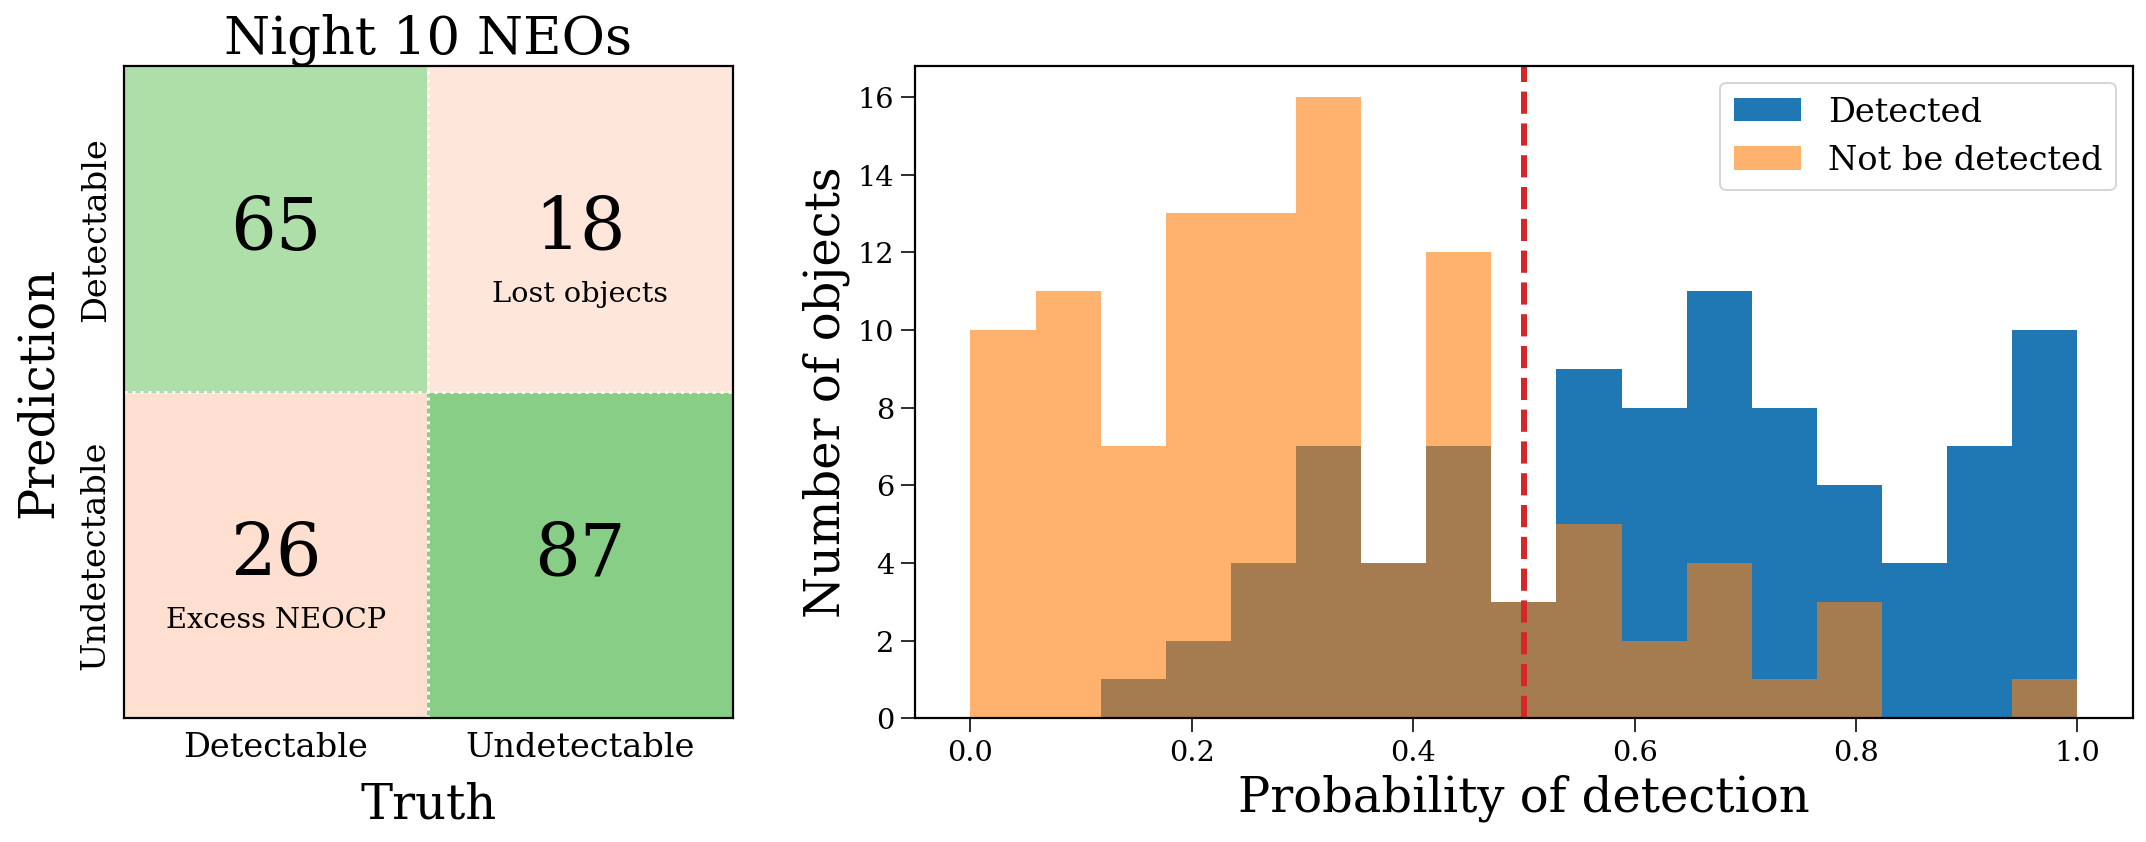

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 2]})

axes[0].set_title(f"Night {night_start} NEOs", fontsize=1.1*fs)

axes[0].axvline(0.5, color="white", linestyle="dotted")
axes[0].axhline(0.5, color="white", linestyle="dotted")

axes[0].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
axes[0].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

axes[0].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
axes[0].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

axes[0].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

axes[0].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(probs)))
axes[0].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(probs)))
axes[0].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(probs)))
axes[0].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(probs)))

axes[0].set_xlabel("\nTruth")
axes[0].set_ylabel("Prediction\n")

axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

bins = np.linspace(0, 1, 18)
axes[1].hist(probs[will_be_detected], label="Detected", bins=bins)
axes[1].hist(probs[np.logical_not(will_be_detected)], alpha=0.6, label="Not be detected", bins=bins)
axes[1].axvline(threshold, color="tab:red", linestyle="--", lw=3)

axes[1].set_xlabel("Probability of detection")
axes[1].set_ylabel("Number of objects")
axes[1].legend(fontsize=0.7*fs)

plt.show()

### okay let's investigate some wrong ones

In [43]:
unique_objs[np.logical_and(probs < 0.3, will_be_detected)]

Index(['00022F2', '0035981', '0009CC0', '000C2E2', '000F110', '0011372',
       '0016AFE', '001850E'],
      dtype='object', name='hex_id')

In [44]:
unique_objs[np.logical_and(probs >= 0.65, np.logical_not(will_be_detected))]

Index(['00000A7', '0001841', '00015B6', '000506E', '002A649', '003382A',
       '000A1EE', '0015C63'],
      dtype='object', name='hex_id')

In [ ]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

In [46]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [9]:
hex_id = "000296A"

In [10]:
%%time
prob, joined_table = detection_probability.probability_from_id(hex_id, sorted_obs,
                                                 np.logspace(-1, 1, 51) * u.AU,
                                                 np.linspace(-100, 100, 21) * u.km / u.s,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list)

CPU times: user 9.1 s, sys: 2.59 s, total: 11.7 s
Wall time: 18.9 s


In [311]:
prob

0.3483443708609272

In [11]:
prob

0.2605820105820106

In [92]:
%%time
reachable_schedule = detection_probability.get_reachable_schedule(sorted_obs.loc[hex_id], first_visit_times,
                                                                  night_list, night_lengths, full_schedule)

CPU times: user 231 ms, sys: 4.94 s, total: 5.17 s
Wall time: 6.02 s


In [93]:
%%time
ephemerides, truth = detection_probability.first_last_pos_from_id(hex_id, sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1, 51) * u.AU,
                                                             np.linspace(-100, 100, 21) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

CPU times: user 1.33 s, sys: 10.6 s, total: 12 s
Wall time: 14.4 s


In [94]:
reload(detection_probability)
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(full_schedule), reachable_schedule=fixed(reachable_schedule),
         ephemerides=fixed(ephemerides), truth=fixed(truth), joined_table=fixed(joined_table),
         night=widgets.IntSlider(min=10, max=24, step=1, value=10, continuous_update=False),
         hex_id=fixed(hex_id),
         colour_by=widgets.Dropdown(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Dropdown(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         filter_mask=widgets.Dropdown(
            value='all',
            options=['all', 'u', 'g', 'r', 'i', 'z', 'y'],
            description='Filter:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
         show_mag_labels=widgets.ToggleButton(
            value=False,
            description='Show mag lims',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Whether to show limiting magnitudes for each field',
            icon='check'),
         fig=fixed(None), ax=fixed(None),show=fixed(True), cbar=fixed(True), ax_labels=fixed(True)
        )

interactive(children=(IntSlider(value=10, continuous_update=False, description='night', max=24, min=10), Dropd…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, ephemerides, joined_table, truth, night, hex_id, colour_by='distance', lims='full_schedule', field_radius=2.1, s=10, filter_mask='all', show_mag_labels=False, fig=None, ax=None, show=True, ax_labels=True, cbar=True)>

# Are particular orbits harder to predict (I guess yes)

Update: I guessed wrong

In [50]:
import thor

In [48]:
true_params = s3m_cart[np.isin(s3m_cart["hex_id"], unique_objs)]

In [51]:
orbits_class = thor.Orbits(orbits=np.atleast_2d(np.concatenate(([true_params["x"], true_params["y"], true_params["z"]],
                                                                [true_params["vx"], true_params["vy"], true_params["vz"]]))).T,
                           epochs=Time(true_params["t_0"], format="mjd"))

In [52]:
orbits_class.keplerian = thor.kepler.convertOrbitalElements(orbits_class.cartesian,
                                                            "cartesian", "keplerian")

In [53]:
q = orbits_class.keplerian[:, 0] * (1 - orbits_class.keplerian[:, 1])

In [54]:
got_it_right = (probs > 0.5) == will_be_detected

In [55]:
colours = ["tab:green" if yup else "tab:red" for yup in got_it_right]

In [56]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


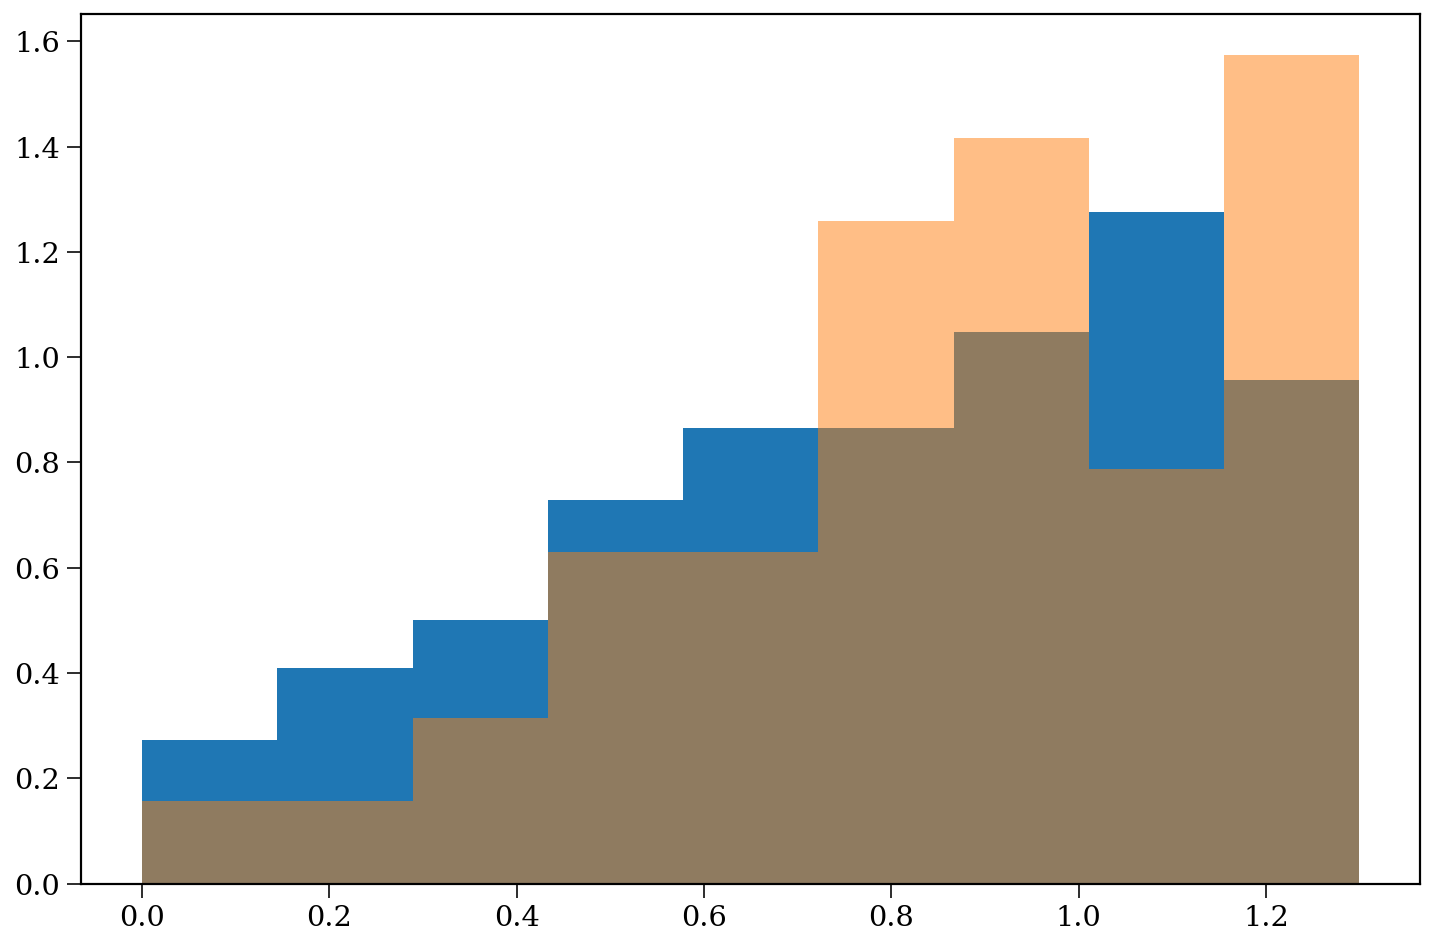

In [64]:
plt.hist(q[got_it_right], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False)
plt.hist(q[np.logical_not(got_it_right)], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, alpha=0.5)
plt.show()

In [78]:
sc = SkyCoord(x=true_params["x"] * u.AU, y=true_params["y"] * u.AU, z=true_params["z"] * u.AU,
         v_x=true_params["vx"] * u.AU / u.day, v_y=true_params["vy"] * u.AU / u.day, v_z=true_params["vz"] * u.AU / u.day,
         frame="heliocentriceclipticiau76", representation_type="cartesian")

In [80]:
sc.transform_to("icrs").dec

<Latitude [-4.26195977e+01, -3.22914713e+01, -2.37231747e+01,
            1.59378369e+01, -4.09777900e+01,  3.78583545e+01,
           -1.06836469e+01, -2.98440073e+01,  5.16319752e-01,
           -3.87691675e+01, -3.50857780e+00,  3.82140340e+00,
           -5.20693997e+00, -3.95406799e+01,  4.33931175e+01,
           -9.75720779e+00, -5.21721060e+01, -5.89266611e+01,
           -2.24026068e+01, -4.80962996e+01, -2.81064499e+01,
            2.93205129e+01,  2.22192286e+01,  2.45959909e+00,
           -1.39388002e+01,  3.78021236e+01, -7.45805364e+00,
           -1.11743370e+00, -4.19530486e+01, -4.92075884e+01,
           -5.41168944e+01,  3.54369955e+00, -1.97183381e+01,
            2.78456311e+01, -2.73656530e+01,  1.96673108e+01,
            2.10235692e+01,  1.14507319e+01, -3.18970816e+01,
           -1.33822790e+01,  2.04241291e+01, -2.48786846e+01,
           -4.52631713e+00,  3.23004632e+01, -2.09499206e+01,
           -2.33388521e+01,  1.84905706e+01,  1.88503133e+01,
        

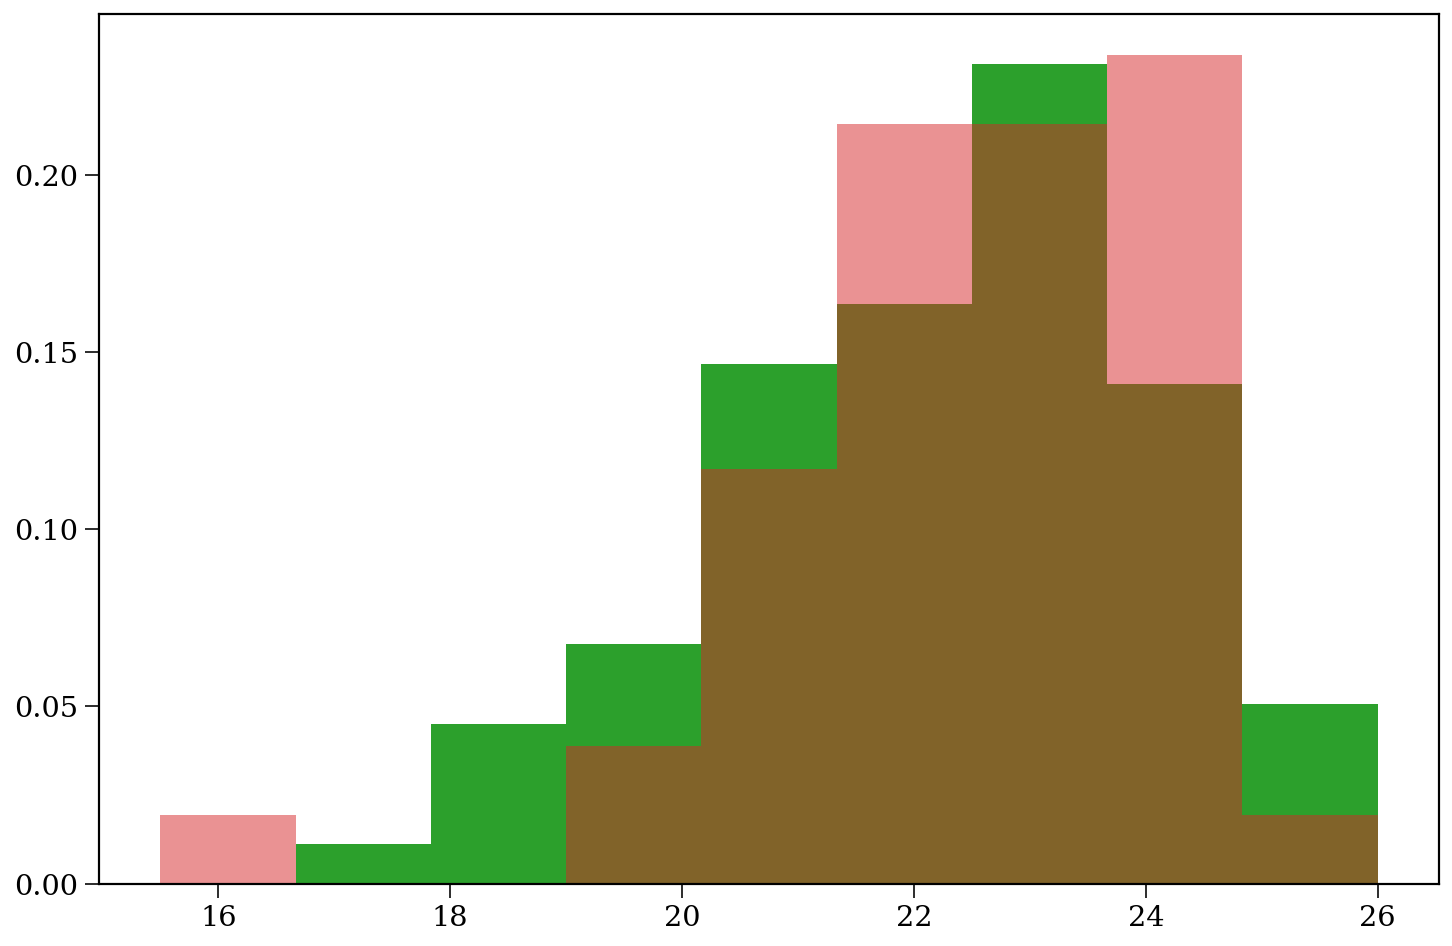

In [66]:
plt.hist(true_params["H"][got_it_right], density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:green")
plt.hist(true_params["H"][np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:red")
plt.show()

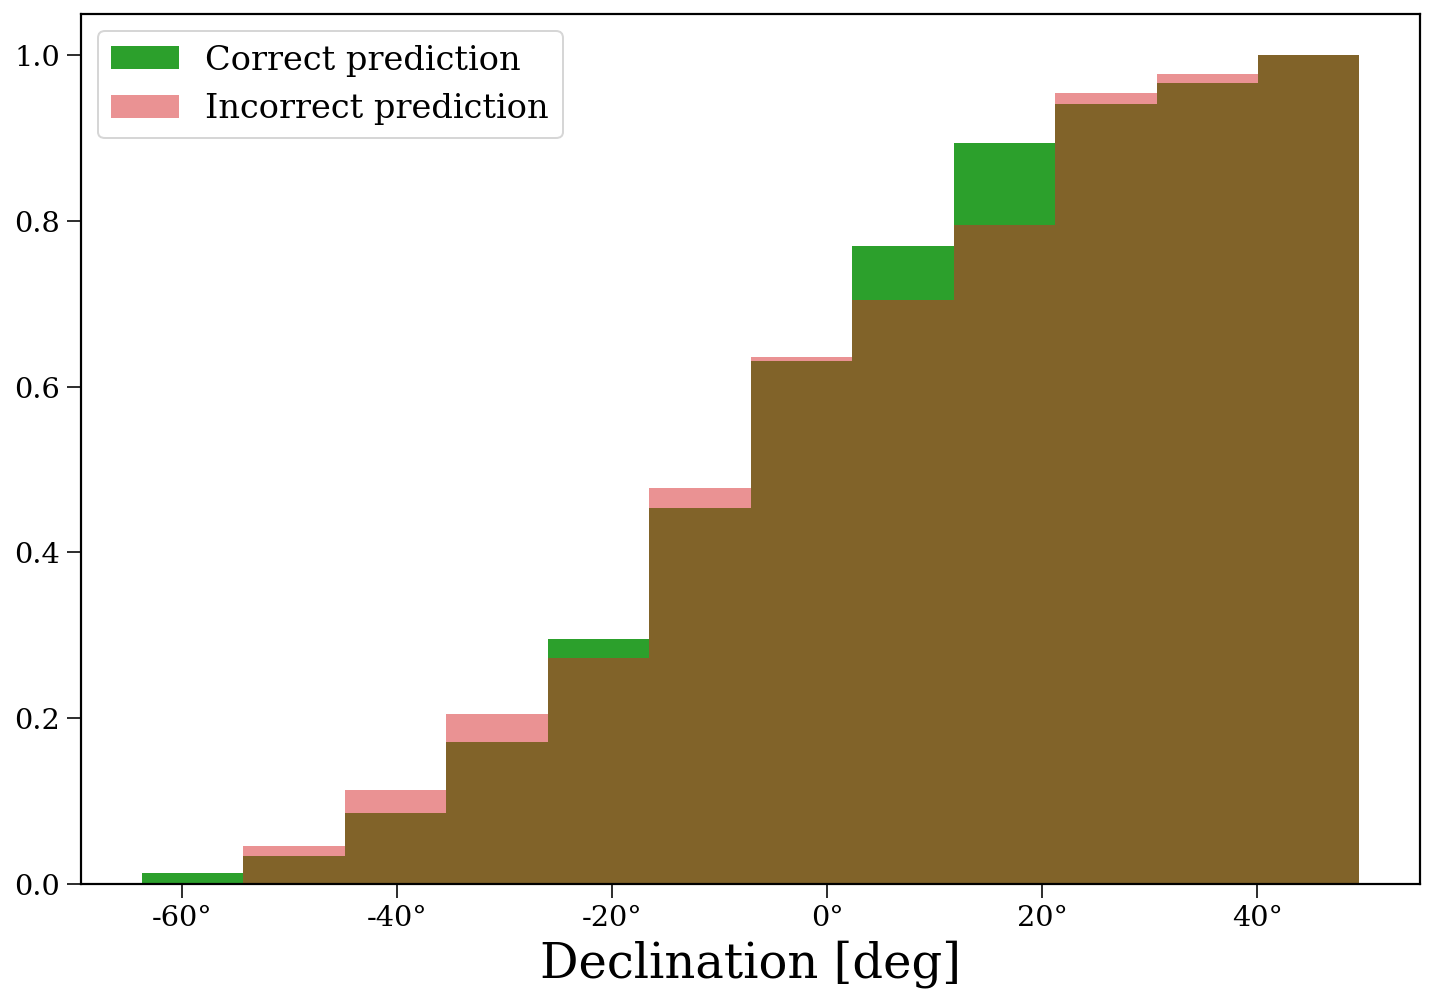

In [89]:
bins = np.linspace(min(sc.transform_to("icrs").dec), max(sc.transform_to("icrs").dec), 13)

plt.hist(sc.transform_to("icrs").dec[got_it_right], density=True, cumulative=True, bins=bins, color="tab:green", label="Correct prediction")
plt.hist(sc.transform_to("icrs").dec[np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=True, bins=bins, color="tab:red", label="Incorrect prediction")

plt.legend(fontsize=0.7*fs)

plt.xlabel("Declination [deg]")

plt.show()

# Probability of each predicted detection based on orbit fraction

In [229]:
for i in range(10, 25):
    x = joined_table[joined_table["observed"] & (joined_table["night"] == i)]
    print(i)
    print(x.groupby("mjd_utc").count()["orbit_id"] / len(joined_table["orbit_id"].unique()) * 100)
    print()

10
mjd_utc
59649.295709    100.0
59649.296156    100.0
59649.320180    100.0
59649.320627    100.0
Name: orbit_id, dtype: float64

11
mjd_utc
59650.330174    100.000000
59650.351728     99.543379
Name: orbit_id, dtype: float64

12
mjd_utc
59651.250333    1.065449
59651.274791    0.913242
Name: orbit_id, dtype: float64

13
mjd_utc
59652.367719    77.625571
59652.376183     0.456621
59652.377078     6.392694
59652.378861    36.834094
59652.387323     0.608828
59652.388219     6.392694
Name: orbit_id, dtype: float64

14
mjd_utc
59653.244888    1.065449
59653.247818    3.500761
59653.268607    1.065449
59653.271480    3.348554
Name: orbit_id, dtype: float64

15
mjd_utc
59654.240757    8.980213
59654.241222    3.500761
59654.241678    0.608828
59654.242138    1.369863
59654.264676    9.132420
59654.265141    3.500761
59654.265598    0.608828
59654.266058    1.522070
Name: orbit_id, dtype: float64

16
mjd_utc
59655.262812     1.674277
59655.263260     2.435312
59655.263715    26.940639
59655

In [205]:
x = joined_table[joined_table["observed"] & (joined_table["night"] == 18)]
x.groupby("mjd_utc").count()["orbit_id"].values / len(joined_table["orbit_id"].unique()) * 100

array([ 0.15384615,  0.76923077, 36.        , 26.30769231,  8.30769231,
       19.38461538, 10.15384615,  2.61538462,  0.15384615,  0.76923077,
       36.30769231, 26.30769231,  8.30769231, 19.53846154, 10.30769231,
        2.46153846,  0.15384615,  0.76923077, 36.        , 26.30769231,
        8.        , 19.53846154, 10.46153846,  2.46153846,  0.15384615,
        0.76923077, 35.84615385, 26.30769231,  8.        , 19.38461538,
       10.76923077,  2.46153846,  0.76923077, 26.30769231,  8.        ,
       19.23076923, 35.84615385,  0.15384615,  0.76923077, 26.15384615,
        8.        , 19.38461538, 35.69230769,  0.15384615,  0.15384615,
        0.76923077, 35.69230769, 26.15384615,  0.15384615,  1.69230769,
       19.69230769, 10.61538462,  2.30769231,  0.15384615,  0.76923077,
       35.53846154, 26.15384615,  0.15384615,  1.84615385, 19.38461538,
       10.61538462,  2.30769231])